# Word2Vec model of abstract text

In this notebook, a word2vec model is trained for each corpus of conference abstracts, which can then be queried for:
- concept similarity: given a term, find the most similar and dissimilar terms to it 
- concept vector arithmetics: can perform vector arithmetic on terms (e.g., memory + motor) to find terms highly similar to the resulting concept
- 2D visualization of ontology: UMAP and TSNE projection of concepts 
- hierarchical clustering of concepts from latent vectors

In [36]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import string, nltk, sys
import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import metrics, manifold
from scipy import cluster
import umap
import matplotlib.pylab as plt
sys.path.append('../')
import cogont as co

pd.set_option('precision', 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Batch processing of all corpora

# Converting to sentences and training word2vec

In [7]:
# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])
terms_concat = co.concat_terms([],terms['Terms'],convert_docs=False)

In [2]:
convert_to_sentences = False
corpora = ['cogsci', 'cns', 'nips']
wv_models = []
for c in corpora:
    abstract_file = '../data/abstracts_'+c+'_combined.csv'
    print('-------%s--------'%c.upper())
    df_corp = pd.read_csv(abstract_file, header=0, index_col=False, usecols=['Year', 'Title', 'Abstract'], na_filter=True)
    print('%i documents extracted. %i with title and abstracts.' %(len(df_corp),len(df_corp.dropna())))    
    
    # convert to sentences
    if convert_to_sentences:
        print('Converting to sentence-level representation & concatenating terms.')
        stcs = co.doc_to_stcs(df_corp)
        stcs, terms_concat = co.concat_terms(stcs, terms['Terms'].values)
        # save sentence lists
        np.save('../data/sentences_%s_concat.npy'%c, stcs)
    else: 
        print('Loading pre-converted sentences.')
        stcs = np.load('../data/sentences_%s_concat.npy'%c)
    
    print('%s sentences in corpus.'%len(stcs))
    
    # train word2vec
    print('Training word2vec model.')
    cur_wv_model = gs.models.Word2Vec(stcs, min_count=2, size=100, window=10, sg=1)
    wv_models.append(cur_wv_model)
    
    print(' ')

-------COGSCI--------
6385 documents extracted. 6379 with title and abstracts.
Loading pre-converted sentences.
45876 sentences in corpus.
Training word2vec model.
 
-------CNS--------
7002 documents extracted. 5067 with title and abstracts.
Loading pre-converted sentences.
58846 sentences in corpus.
Training word2vec model.
 
-------NIPS--------
4909 documents extracted. 4830 with title and abstracts.
Loading pre-converted sentences.
35921 sentences in corpus.
Training word2vec model.
 


# Similarity query across models

In [48]:
dissim = True
cmap = 'RdBu' if dissim else 'PuBu'
top_n = 10
positive = ['working-memory']
negative = []#['attention']

df_similarity = co.query_similarity(wv_models, [c.upper() for c in corpora], positive, negative, top_n, terms_concat, dissim)
co.print_fancy_similarity(df_similarity, cmap)

Positive terms: working-memory 
Negative terms: 


# 2D projection
Here, we can use PCA, tSNE, or UMAP to embed the word vectors and project onto 2D space for visualization.
Too many terms to include from the full dictionary, so just display and label the cognitive ontology words.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


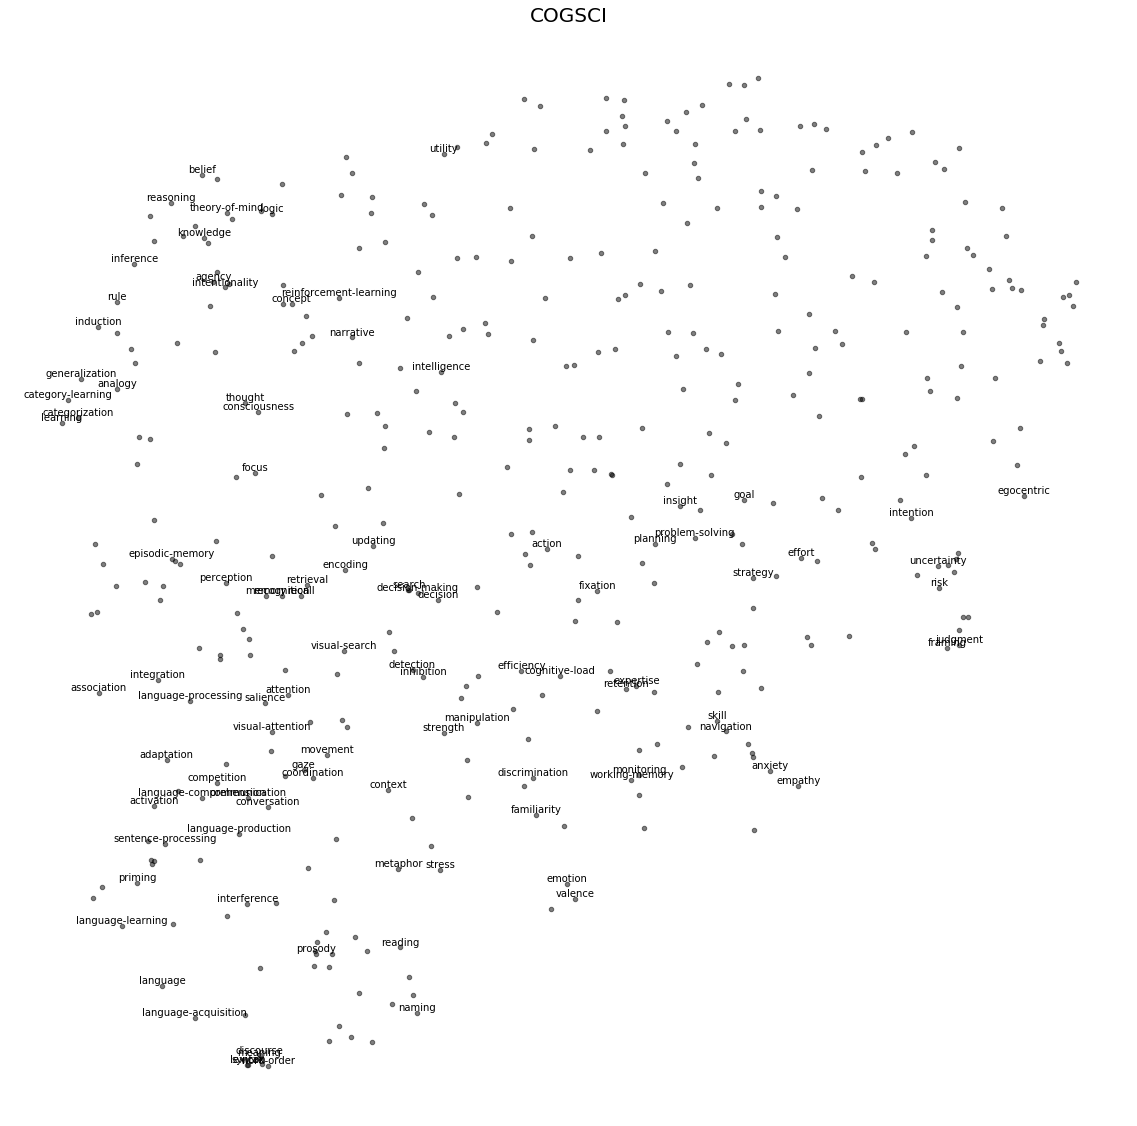

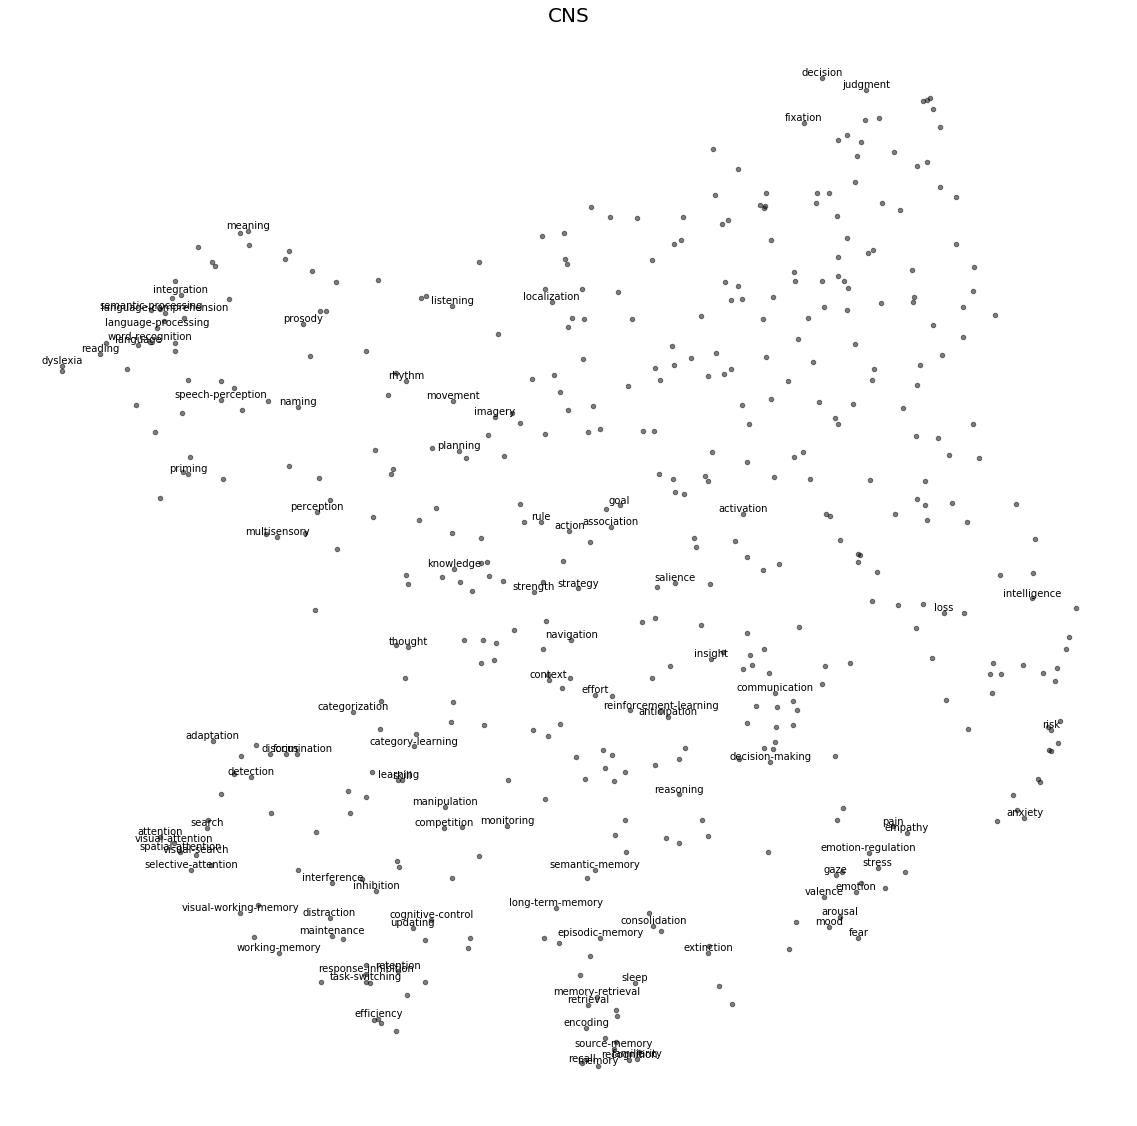

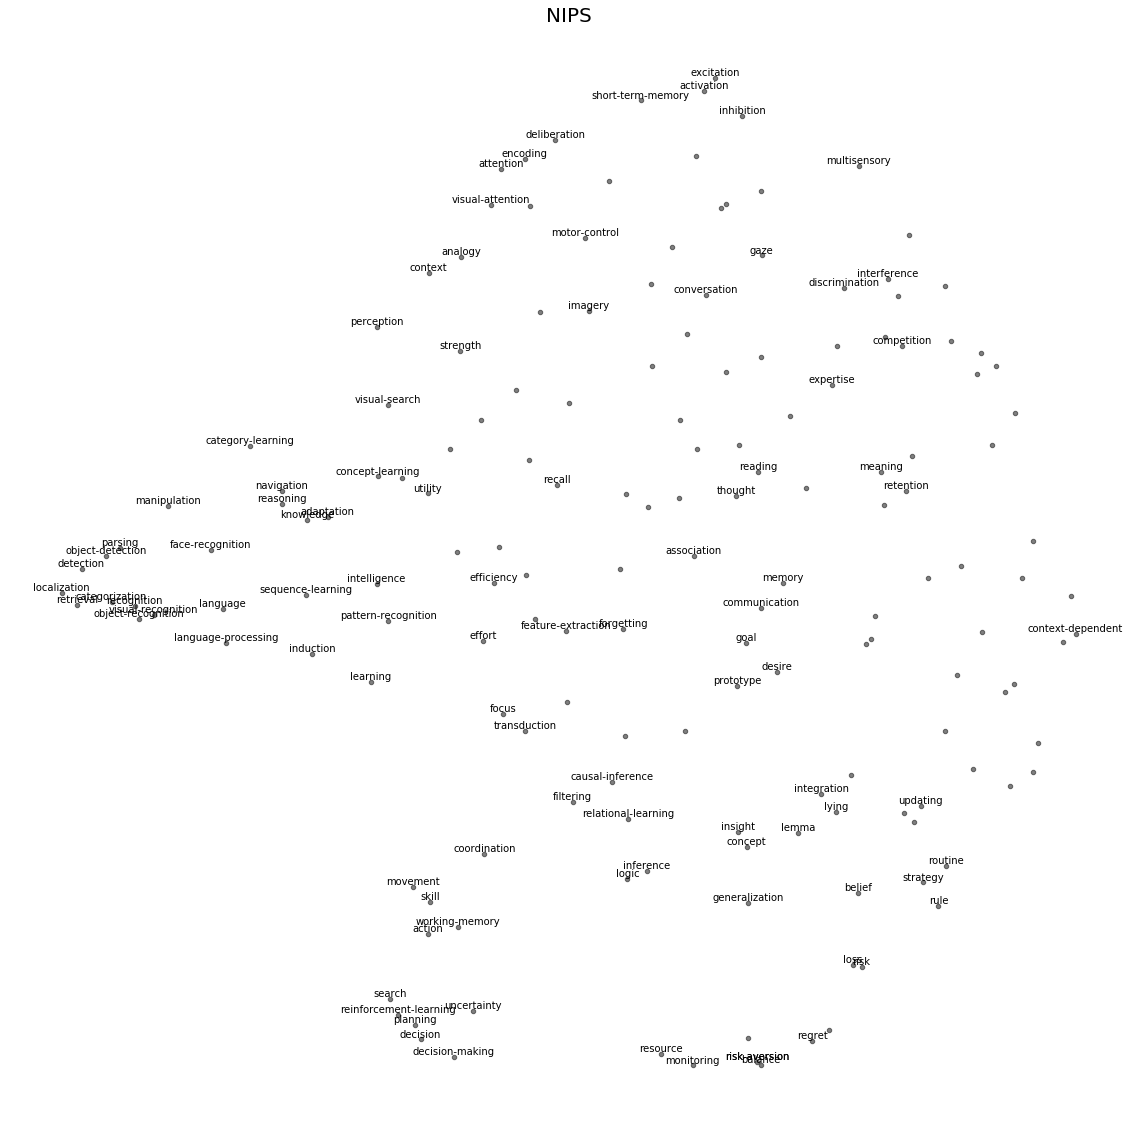

In [34]:
proj_method = 'UMAP'
for m_i, m in enumerate(wv_models):
    vocab = m.wv.index2word
    subset_inds = co.return_subset_inds(vocab, terms_concat)
    top_inds, top_counts, top_terms = co.get_top_terms(m, terms_concat, topn=100)
    
    if proj_method == 'UMAP':
        projection = umap.UMAP().fit_transform(m.wv.vectors_norm[subset_inds])
    elif proj_method == 'TSNE':
        projection = manifold.TSNE(n_components=2).fit_transform(m.wv.vectors_norm[subset_inds])

    plt.figure(figsize=(20,20))
    plt.scatter(projection[:,0], projection[:,1], s=20, c='k', alpha=0.5)    
    for t_i, t in enumerate(top_terms):
        # do some more gymnastics to get equivalent index in the subset
        s_i = subset_inds.index(top_inds[t_i])
        plt.text(projection[s_i,0], projection[s_i,1], t, ha="center", va="bottom", rotation=0)
    plt.title(corpora[m_i].upper(), fontsize=20)
    plt.box('off');plt.xticks([]);plt.yticks([])
    #plt.savefig('../figures/%s_proj2d_%s.png'%(proj_method, corpora[m_i]))

# Hierarchical Clustering

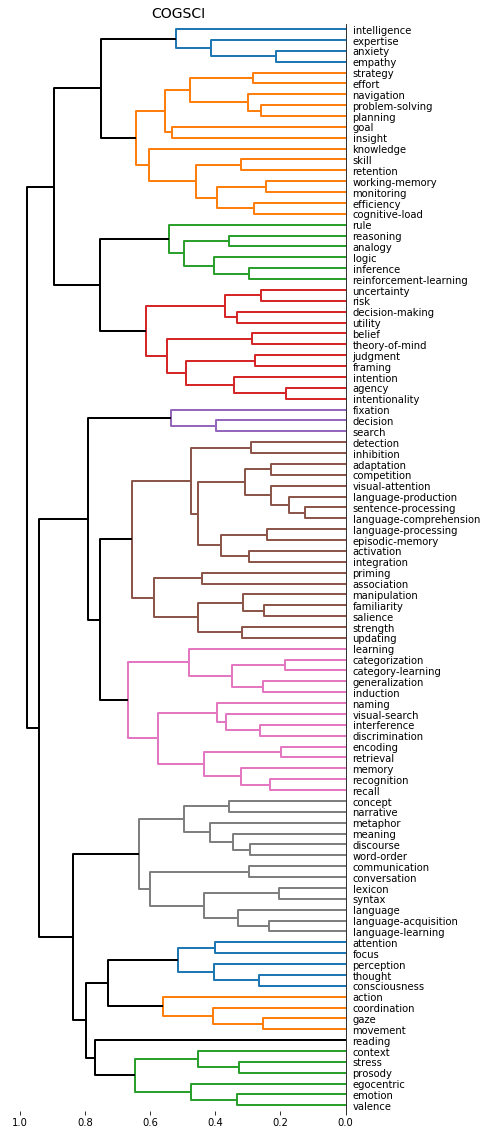

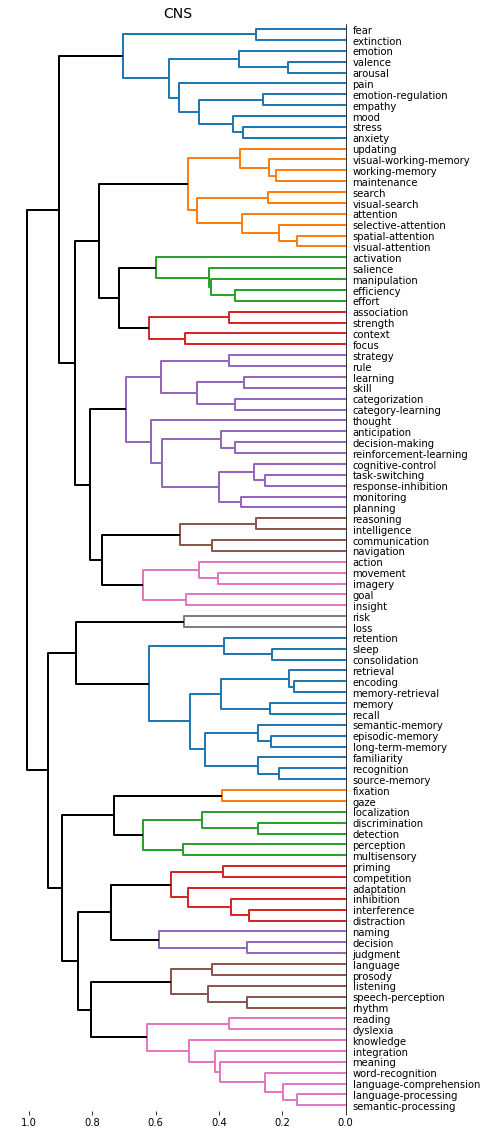

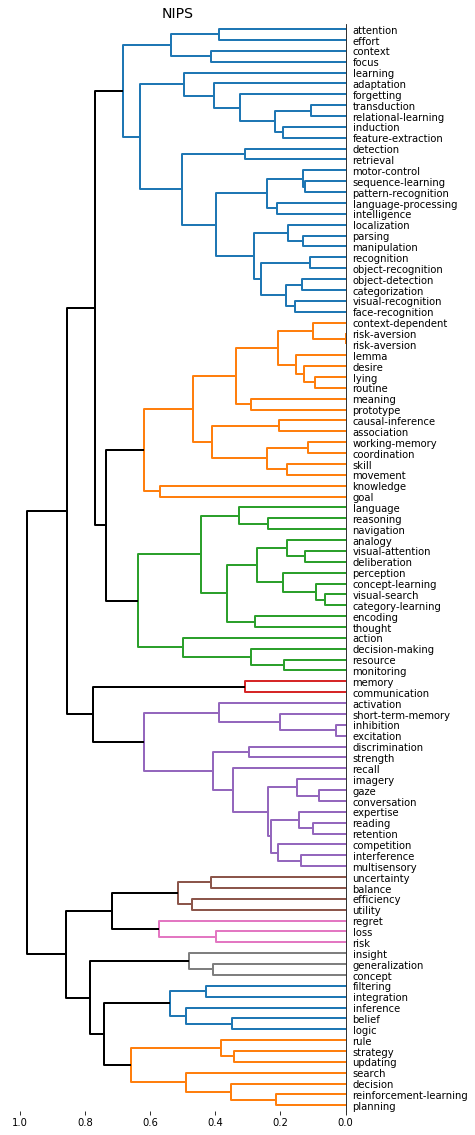

In [41]:
clist = [colors.rgb2hex(plt.cm.get_cmap('tab10')(i)) for i in range(8)] # tab10, Set1
sp.cluster.hierarchy.set_link_color_palette(clist)
plt.rcParams['lines.linewidth'] = 2

for m_i, m in enumerate(wv_models):
    plt.figure(figsize=(6,20))
    top_inds, top_counts, top_terms = co.get_top_terms(m, terms_concat, topn=100)

    # clustering
    Y = cluster.hierarchy.linkage(m.wv.vectors_norm[top_inds], method='complete', metric='cosine')
    Z = cluster.hierarchy.dendrogram(Y,
                   orientation='left',
                   labels=top_terms,
                   leaf_font_size=10,
                   above_threshold_color='k')
    plt.gca().invert_yaxis(); co.remove_spines(plt.gca(),['top','left', 'bottom'])
    plt.title(corpora[m_i].upper(), fontsize=14)
    plt.savefig('../figures/hierarchical_%s.png'%corpora[m_i], bbox_inches='tight')
